# Run level 2A and 2B pipelines on LRS-SLITLESS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) June 28th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS-SLITLESS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with a blackbody spectrum plus emission lines. One file represents the on-source observation, while the second is an off-source observation which will be subtracted from the on-source observation. 

Also, because of the current uncertainty in some metadata in slitless prism subarray data, we must manually set the array name to what the pipeline expects, ie.:

dm.meta.subarray.name = 'SUBPRISM'

#### NB: The final extracted spectrum will not have the correct shape. This is due to ongoing uncertainty regarding the correct reference position for the slitless prism subarray.


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'LRS-SLITLESS_demo_data'
input_dir = 'LRS-SLITLESS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-SLITLESS	 P750L	 SLITLESSPRISM	 2	 50	 FAST	 11.8



Filename: LRS-SLITLESS_demo_data/det_image_1_MIRIMAGE_P750Lexp1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     145   ()      
  1  SCI         ImageHDU        14   (72, 416, 50, 2)   float32   
  2  REFOUT      ImageHDU        14   (18, 416, 50, 2)   float32   
  3  PIXELDQ     ImageHDU        10   (72, 416)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF        ImageHDU         7   (20270816,)   uint8   


#### show the last frame of the first integration for each file

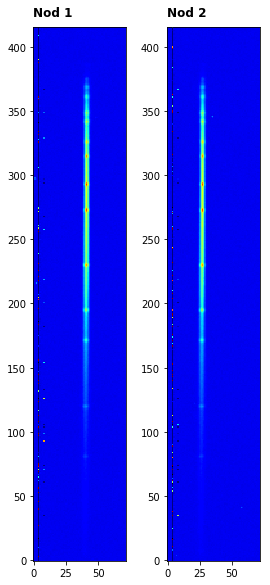

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(4, 8))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.2e4))
        axs[i].annotate('Nod %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import SloperPipeline
print SloperPipeline.__doc__



    SloperPipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    and ramp_fit.

    


For MIRI, the steps in order are: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

NOTE: As dark current was switched off in the MIRISim simulations, we will skip the dark_current step in the call to the SloperPipeline

#### run pipeline
The output of the level 2A pipeline is contained in the dm_2A data model, which we add to a model container. This s also saved to a fits file ending in '_rate.fits'. Saving the fits file is optional

In [6]:
dm_2A_container = datamodels.ModelContainer()
for input_file in input_files:
    # set the subarray name here
    dm = datamodels.open(input_file)
    dm.meta.subarray.name = 'SUBPRISM'
    dm_2A = SloperPipeline.call(dm, save_results=True, output_dir=output_dir, steps={'dark_current':{'skip':True}})
    dm_2A_container.append(dm_2A)

2017-06-29 08:32:19,631 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-06-29 08:32:19,632 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-06-29 08:32:19,634 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-06-29 08:32:19,636 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-06-29 08:32:19,637 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-06-29 08:32:19,639 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-06-29 08:32:19,640 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-06-29 08:32:19,642 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-06-29 08:32:19,644 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-06-29 08:32:19,645 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-06-29 08:32:19,647 - stpipe.SloperPipeline.dq_ini

#### quick check of output. We'll look at the first dither

In [7]:
# check the calibration step information
print'Check step information status:'
print 'dq_init: %s' % dm_2A_container[0].meta.cal_step.dq_init
print 'saturation: %s' % dm_2A_container[0].meta.cal_step.saturation
print 'linearity: %s' % dm_2A_container[0].meta.cal_step.linearity
print 'rscd: %s' % dm_2A_container[0].meta.cal_step.rscd
print 'lastframe: %s' % dm_2A_container[0].meta.cal_step.lastframe
print 'dark_current: %s' % dm_2A_container[0].meta.cal_step.dark_sub
print 'refpix: %s' % dm_2A_container[0].meta.cal_step.refpix
print 'jump: %s' % dm_2A_container[0].meta.cal_step.jump
print 'ramp_fit: %s' % dm_2A_container[0].meta.cal_step.ramp_fit

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: SKIPPED
jump: COMPLETE
ramp_fit: COMPLETE


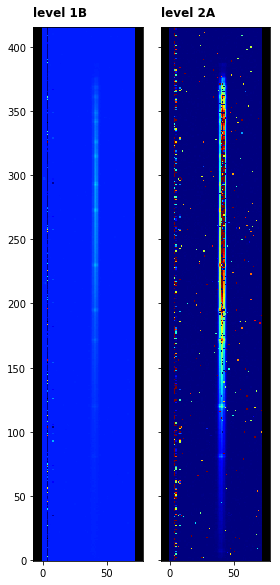

In [9]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(4, 8), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs[0].annotate('level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm_2A_container[0].data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=100)
    axs[1].annotate('level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [10]:
from jwst.pipeline import Spec2Pipeline
print Spec2Pipeline.__doc__


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, photom, resample_spec,
    cube_build, and extract_1d.
    


For the LRS, the level 2B steps in order are: assign_wcs, bkg_subtract, flat_field, srctype, photom, cube_build, extract_1d

The bkg_subtract subtract step requires an association file defining the source and background exposures. At the moment, there is no easy way to create one, so we define it manually in a cell and write to the association json file. 

In [11]:
import json

data = {
    "asn_rule": "Asn_Lv2Spec",
    "asn_pool": "dummy_pool",
    "program": "00000",
    "asn_type": "spec2",
    "products": [
        {
            "name": "lrs_bgsub",
            "members": [
                {
                    "expname": "LRS-SLITLESS_demo_data_pipelined/det_image_1_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "LRS-SLITLESS_demo_data_pipelined/det_image_2_MIRIMAGE_P750Lexp1_rate.fits",
                    "exptype": "background"
                }
            ]
        }
    ]
}

with open('LRS_bg-sub_lvl2_asn.json', 'w') as outfile:  
    json.dump(data, outfile)

#### run pipeline
We pass the level 2 assocation file. The output is contained in the dm_2B data model and saved to a fits file ending in '_bgsub_cal.fits'. Saving this fits file is optional. A 1D spectrum is also saved (see below). 

In [12]:
dm_2B = Spec2Pipeline.call('LRS_bg-sub_lvl2_asn.json', save_results=True, output_dir=output_dir, steps={'extract_1d':{'save_results':True}})


2017-06-28 20:24:28,836 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-06-28 20:24:28,839 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2017-06-28 20:24:28,842 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-06-28 20:24:28,844 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-06-28 20:24:28,846 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2017-06-28 20:24:28,847 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2017-06-28 20:24:28,850 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-06-28 20:24:28,852 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-06-28 20:24:28,853 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-06-28 20:24:28,854 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2017-06-28 20:24:

### check of output

The level 2B pipeline for the LRS-SLIT produces two files for each input:

_bgsub_cal.fits - the background subtracted calibrated level 2B file

_bgsub_x1d.fits - the background subtracted 1d spectrum

We can have a look at each of these

In [13]:
# set the output file names
level2B_file = glob.glob(os.path.join(output_dir,'*_cal.fits'))[0]
spec_file = glob.glob(os.path.join(output_dir,'*_x1d.fits'))[0]

#### level 2B file

In [14]:
# check the calibration step information
print'Check step information status:'
print 'assign_wcs: %s' % dm_2B.meta.cal_step.assign_wcs
print 'bkg_subtract: %s' % dm_2B.meta.cal_step.back_sub
print 'flat_field: %s' % dm_2B.meta.cal_step.flat_field
print 'srctype: %s' % dm_2B.meta.cal_step.srctype
print 'photom: %s' % dm_2B.meta.cal_step.photom


Check step information status:
assign_wcs: COMPLETE
bkg_subtract: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
photom: COMPLETE


#### calibrated image

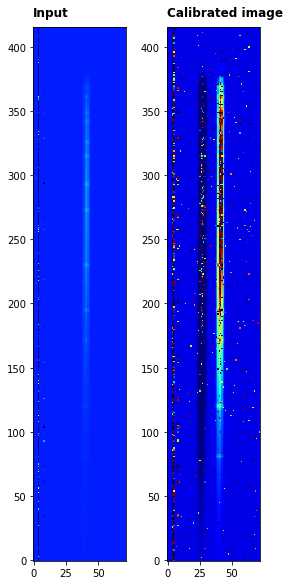

In [18]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_file) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(4, 8))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
        axs[0].annotate('Input', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-10, vmax=100)
        axs[1].annotate('Calibrated image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### 1D spectrum

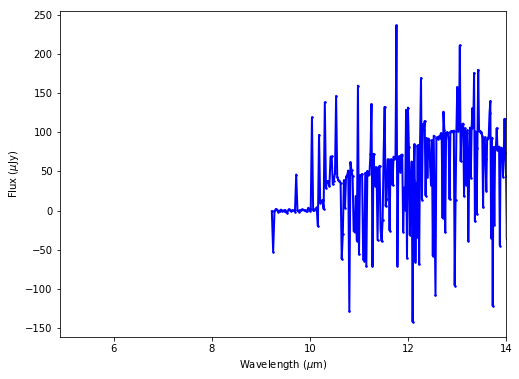

In [16]:
from jwst.datamodels import SpecModel

# open the spectrum as a jwst data model
with SpecModel(spec_file) as spec_dm:
    # plot--------------------------------------
    # simple XY plot of the spectrum
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))

    # plot the spectrum in the channel 2 wavelength range
    axs.plot(spec_dm.spec_table['WAVELENGTH'][1:-1], spec_dm.spec_table['FLUX'][1:-1], c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
    axs.set_ylabel(r'Flux ($\mu$Jy)')
    axs.set_xlabel(r'Wavelength ($\mu$m)')
    axs.set_xlim(4.9,14.)
    #axs.set_ylim(0,6000)
    plt.show()

Note that the spectrum does not have the expected shape. This is due to ongoing uncertainty regarding the correct reference position for the slitless prism subarray.